Error reduction factor from 0 to 1: 0.7471541859697499
Error reduction factor from 1 to 2: 0.8779619664995869
Error reduction factor from 2 to 3: 0.941326966632819
Error reduction factor from 3 to 4: 0.9714297833111645
Error reduction factor from 4 to 5: 0.9859306212736094
Error reduction factor from 5 to 6: 0.9930223780246953
Error reduction factor from 0 to 1: 2.3894707860359605
Error reduction factor from 1 to 2: 2.704164651929745
Error reduction factor from 2 to 3: 2.831179966876641
Error reduction factor from 3 to 4: 2.8896335952946712
Error reduction factor from 4 to 5: 2.9232525482630534
Error reduction factor from 5 to 6: 2.9454771922227643
Error reduction factor from 0 to 1: 4.860378007107561
Error reduction factor from 1 to 2: 5.027526972611627
Error reduction factor from 2 to 3: 5.164448955194613
Error reduction factor from 3 to 4: 5.682195286815083
Error reduction factor from 4 to 5: 6.339827662906345
Error reduction factor from 5 to 6: 2.03953463690347
Error reduction fact

,timesteps,Residual (order1),Residual (order2),Residual (order4),Residual (order8)
0,4,2.919439e-15,1.951536e-09,1.719524e-08,9.340638e-13
1,8,1.574743e-15,2.800102e-10,6.008760e-10,1.782468e-15
2,16,8.091729e-16,3.492072e-11,1.764262e-11,1.179842e-16
3,32,3.921921e-16,3.714832e-12,4.603739e-13,6.469292e-17
4,64,2.014197e-16,3.914851e-13,4.506359e-13,3.515089e-17
5,128,8.662494e-17,6.105007e-13,3.510364e-14,1.739963e-17
6,256,4.392565e-17,9.300069e-13,8.441747e-16,1.093991e-17


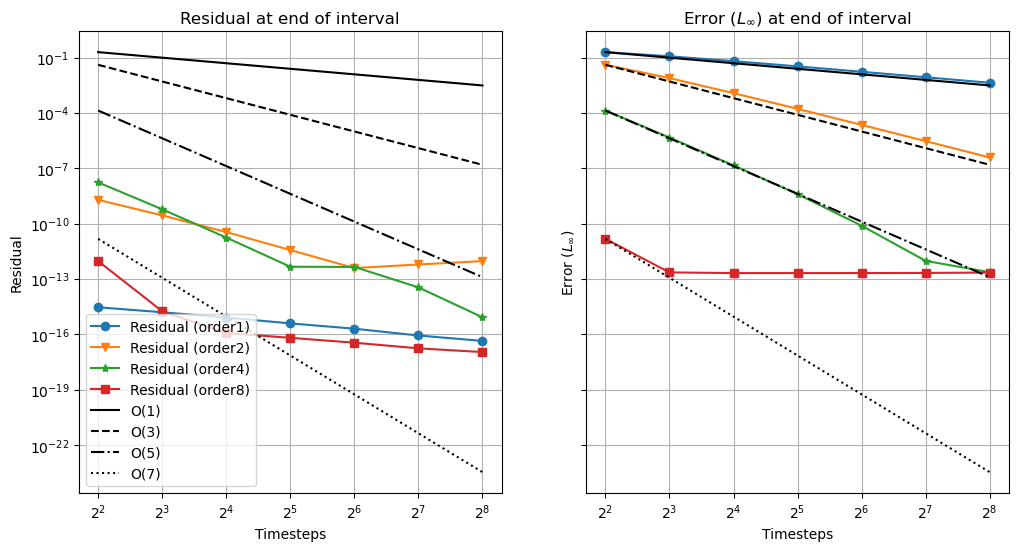

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math as Math


def getRefY(x_vals, orders, start_vals):
    res = []
    
    for order in orders:
        res.append([0.5**(order * (Math.log(x/x_vals[0], 2))) * start_vals[orders.index(order)] for x in x_vals])
        
    return res


mesh_type = "RECTANGLE_2x1" # "UNIT_SQUARE" or "RECTANGLE_2x1"
equation = "POLY_N"
orders = ["order1", "order2", "order4", "order8"]

print_full_stats = False
convergence_analysis = True

if print_full_stats:
    for order in orders:
        data_dir = f"data/{mesh_type}/{equation}/{order}"
        full_stats_files = os.listdir(data_dir + "/statistics")
        for file in full_stats_files:
            if file.endswith(".csv"):
                df = pd.read_csv(f"{data_dir}/statistics/{file}")
                print(df)
                
if convergence_analysis:
    residual_df = pd.DataFrame()
    error_df = pd.DataFrame()
    for order in orders:
        file_path = f"data/{mesh_type}/{equation}/{order}/convergence_data.csv"
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            orders.remove(order)
            continue
        
        # Print factor of reduction in residual and error from one row to the next
        errors = df["final_error"]
        for i in range(1, len(errors)):
            print(f"Error reduction factor from {i-1} to {i}: {Math.log(errors[i-1]/errors[i], 2)}")
        
        df.rename(columns={"error": f"error_{order}", "residual": f"residual_{order}"}, inplace=True)
        
        if residual_df.empty:
            residual_df.insert(0, "timesteps", df["timesteps"])
            
        if error_df.empty:
            error_df.insert(0, "timesteps", df["timesteps"])
        
        residual_df.insert(len(residual_df.columns), f"Residual ({order})", df["final_residual"])
        error_df.insert(len(error_df.columns), f"Error ({order})", df["final_error"])



    # Plotting the convergence data

    fig, (residual_ax, error_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
    markers = ["o", "v", "*", "s", "D", "^", "1"]

    for index, order in enumerate(orders):
        residual_ax.plot(
                "timesteps",
                f"Residual ({order})",
                data=residual_df,
                marker=markers[index],
                )
        error_ax.plot(
                "timesteps",
                f"Error ({order})",
                data=error_df,
                marker=markers[index],
                )
    
    
    ref_orders = [1, 3, 5, 7]
    x_vals = residual_df["timesteps"]
    linestyles = ["-", "--", "-.", ":"]
    
    start_vals = []
    for order in orders:
        start_vals.append(error_df[f"Error ({order})"][0])
    
    ref_y = getRefY(x_vals, ref_orders, start_vals)
    
    for i, ref in enumerate(ref_y):
        residual_ax.plot(x_vals, ref, label=f"O({ref_orders[i]})", linestyle=linestyles[i], color="black")
        error_ax.plot(x_vals, ref, label=f"O({ref_orders[i]})", linestyle=linestyles[i], color="black")

    residual_ax.set_title("Residual at end of interval")
    residual_ax.set_ylabel("Residual")
    error_ax.set_title("Error ($L_\infty$) at end of interval")
    error_ax.set_ylabel("Error ($L_\infty$)")
    for ax in [residual_ax, error_ax]:           
        ax.set_xscale("log", base=2)
        ax.set_yscale("log", base=10)
        ax.set_xlabel("Timesteps")
        ax.grid(True)

    #box = residual_ax.get_position()
    #residual_ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    residual_ax.legend()

residual_df
